Advanced lane finding
=====================

> The goals / steps of this project are the following: 
> * Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
> * Apply a distortion correction to raw images.
> * Use color transforms, gradients, etc., to create a thresholded binary image.
> * Apply a perspective transform to rectify binary image ("birds-eye view").
> * Detect lane pixels and fit to find the lane boundary.
> * Determine the curvature of the lane and vehicle position with respect to center.
> * Warp the detected lane boundaries back onto the original image.
> * Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Targets:
- `test_images`: run per image, save output with intermediary steps in `test_images_output`
- `test_videos`: run on entire video, do not save intermediary output. Also, only use sliding window once and use previous polynomial as prior for subsequent frames.

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cv2
import numpy as np

from lib.constants import IMG_SHAPE, LANE_AREA_SRC, LANE_AREA_DST
from lib.camera_calib import Undistorter
from lib.lane_pixel_ops import binarize_lane_line_pixels, BirdsEyeTansformer
from lib.line import Line, LineType
from lib.road_lane import RoadLane

%matplotlib inline

In [3]:
PATH_CAM_CALIBRATION_IMAGES = list(Path("./camera_cal").glob("calibration*.jpg"))
TEST_IMAGES = sorted(Path("./test_images").glob("*.jpg"))

In [4]:
undist = Undistorter(IMG_SHAPE)
undist.calibrate(PATH_CAM_CALIBRATION_IMAGES)

bird_trans = BirdsEyeTansformer()

In [5]:
def visualize_undistorted_with_perspective_areas(ax, img):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title("Undistorted")
    
    ax.add_patch(Polygon(LANE_AREA_SRC, linewidth=1, edgecolor="lime", facecolor="none", 
                        linestyle="--", label="Lane area source"))
    ax.add_patch(Polygon(LANE_AREA_DST, linewidth=1, edgecolor="pink", facecolor="none", 
                        linestyle="--", label="Lane area destination"))
    ax.legend()

In [11]:
def visualize_process_steps(img_path, img_dist, img, img_bin, img_bird, lane_line_left, lane_line_right):
    _, ((t1, t2, t3, t4), (b1, b2, b3, b4)) = plt.subplots(nrows=2, ncols=4, figsize=(18, 6))
    t1.imshow(cv2.cvtColor(img_dist, cv2.COLOR_BGR2RGB))
    t1.set_title("Original")
    
    visualize_undistorted_with_perspective_areas(t2, img)

    cmap = "gray" if len(img_bin.shape) == 2 else None
    t3.imshow(img_bin, cmap=cmap)
    t3.set_title("Lane pixel extraction")
    
    t4.imshow(img_bird, cmap=cmap)
    t4.set_title("Perspective transform")

    for lane_line, ax in zip((lane_line_left, lane_line_right), ((b1, b2))):
        ax.imshow(lane_line.sw_fit_viz)
        ax.set_title(f"{LineType.to_str(lane_line.line_type)} - "
                     f"radius of curvature: {lane_line.radius_of_curvature:.1f} km")

    plt.suptitle(img_path.name)
    plt.savefig("test_images_output/steps_" + img_path.stem + ".png")
    plt.tight_layout()
    plt.show()
    plt.close()

Lane mean Radius of Curvature: 6.4 km
Car relative position: -0.02 m


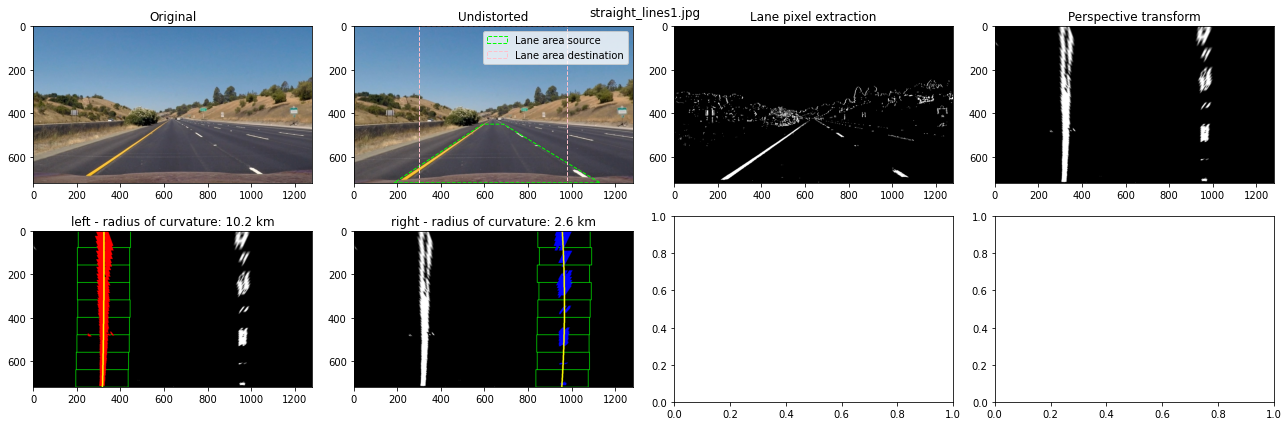

Lane mean Radius of Curvature: 9.9 km
Car relative position: 0.01 m


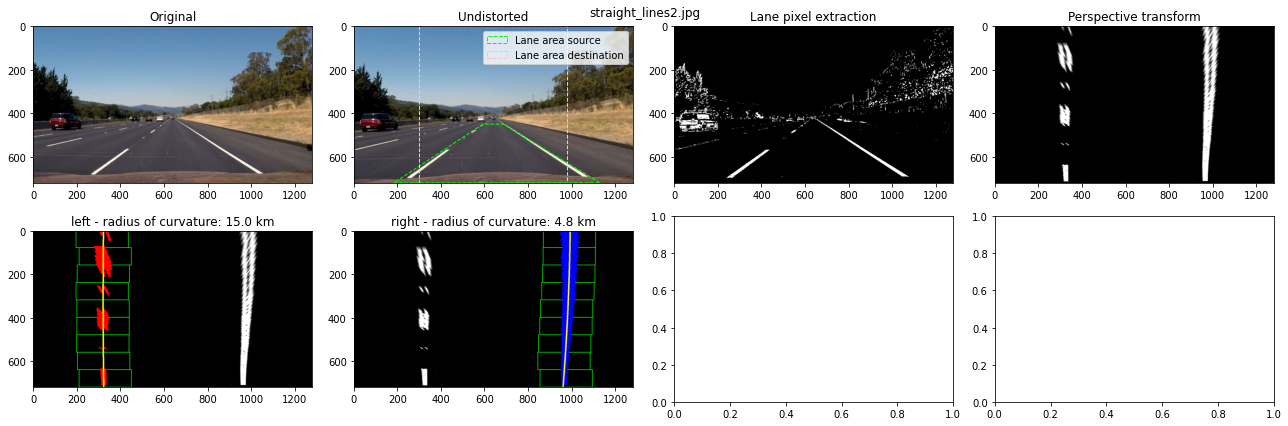

Lane mean Radius of Curvature: 0.6 km
Car relative position: 0.13 m


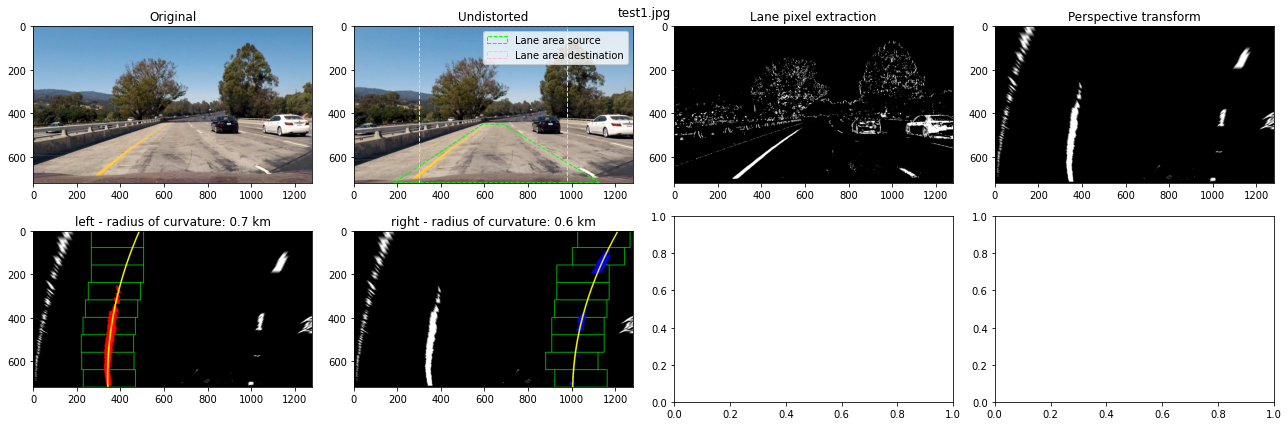

Lane mean Radius of Curvature: 0.5 km
Car relative position: 0.21 m


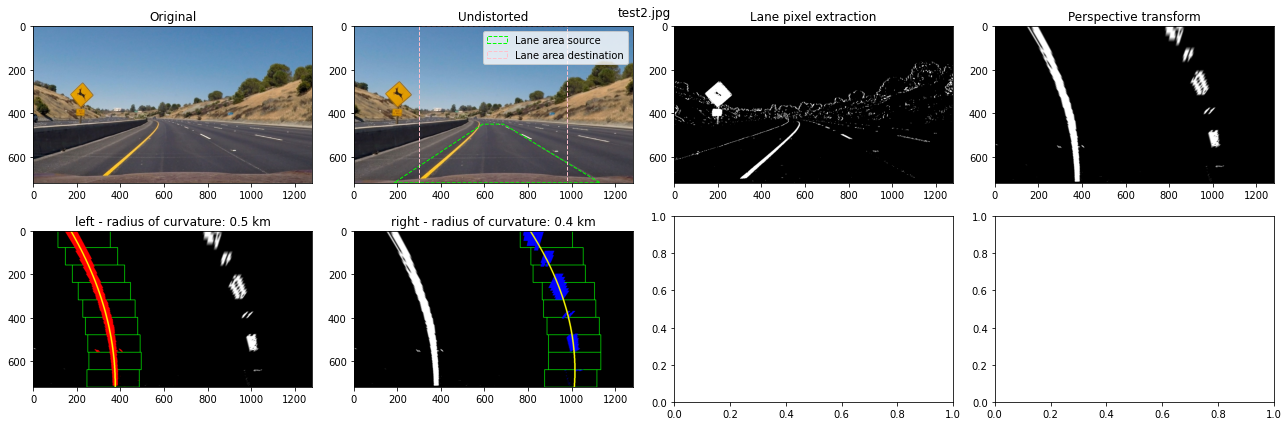

Lane mean Radius of Curvature: 0.8 km
Car relative position: 0.08 m


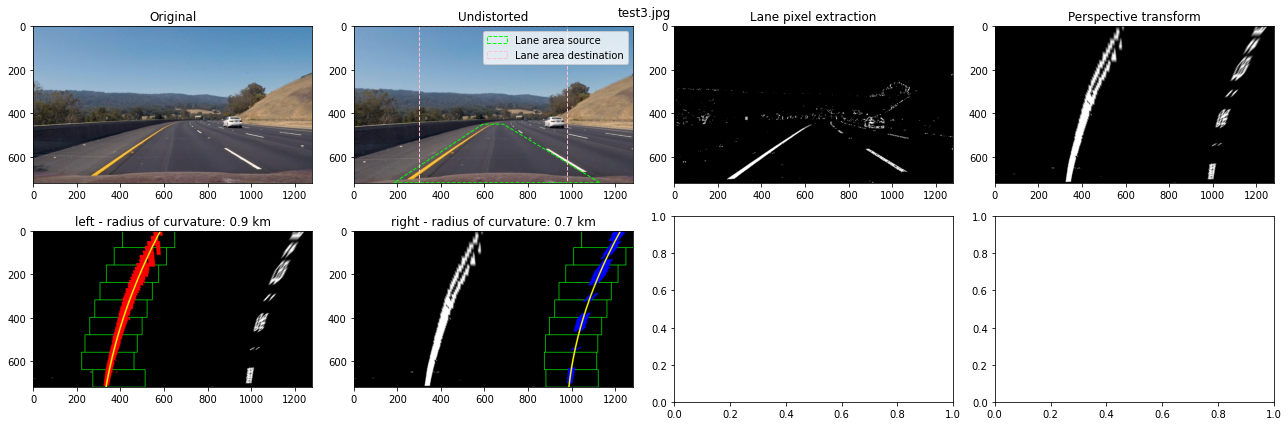

Lane mean Radius of Curvature: 0.9 km
Car relative position: 0.19 m


In [ ]:
for img_path in TEST_IMAGES:
    img_dist = cv2.imread(str(img_path))

    img = undist.apply(img_dist)
    
    img_bin = binarize_lane_line_pixels(img, output_binary=True, s_thresh=(155, 255),  sx_thresh=(40, 140))

    img_bird = bird_trans.apply(img_bin)

    lane_line_left = Line.from_sliding_window(img_bird, LineType.LEFT)
    lane_line_right = Line.from_sliding_window(img_bird, LineType.RIGHT)

    lane = RoadLane(lane_line_left, lane_line_right)
    print(f"Lane mean Radius of Curvature: {lane.radius_of_curvature:.1f} km")
    print(f"Car relative position: {lane.vehicle_rel_position:.2f} m")
        
    # Warp lane lines back onto undistorted image + add curvature and position of vehicle details
    
    visualize_process_steps(img_path, img_dist, img, img_bin, img_bird, lane_line_left, lane_line_right)

